In [1]:
import sys
sys.path.append('../utils')
from sdmbench import compute_ARI, compute_NMI, compute_CHAOS, compute_PAS, compute_ASW, compute_HOM, compute_COM
from load_st_data import load_mHypothalamus

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import warnings
warnings.filterwarnings('ignore')

/Users/toanne/anaconda3/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/toanne/anaconda3/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/toanne/anaconda3/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/toanne/anaconda3/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/toanne/anaconda3/envs/SEDR/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing 

In [2]:
pred_keys = {'BayesSpace': 'spatial.cluster',
             'conST': 'conST_leiden',
             'DeepST': 'DeepST_refine_domain',
             'GraphST': 'domain',
             'PRECAST': 'cluster',
             'SEDR': 'SEDR',
             'Seurat': 'seurat_clusters',
             'SpaceFlow': 'pred',
             'SpaGCN': 'refined_pred',
             'STAGATE': 'STAGATE',
             'stLearn': 'X_pca_kmeans',
             'BASS': 'pred'}

In [ ]:
method = 'Seurat'
pred_key = pred_keys[method]
umap_keys = ['umap_1', 'umap_2']
# umap_keys = ['UMAP1', 'UMAP2'] 
dataset = 'mHypothalamus'

data_folder = f'../data/{dataset}'
input_dir = f'../Results/MERFISH/{dataset}/{method}'
output_dir = f'../Results/MERFISH/{dataset}/{method}'
os.makedirs(output_dir, exist_ok=True)

files = glob.glob(input_dir + '/*')
files = [f for f in files if os.path.isdir(f)]

print(method)
print(files)

Seurat
['../Results/MERFISH/mHypothalamus/Seurat/-0.24', '../Results/MERFISH/mHypothalamus/Seurat/-0.14', '../Results/MERFISH/mHypothalamus/Seurat/-0.09', '../Results/MERFISH/mHypothalamus/Seurat/-0.19', '../Results/MERFISH/mHypothalamus/Seurat/-0.04']


In [13]:
fontsize = 12
def plot_clustering(adata, metrics, out_path, show=True):
    fig, axes = plt.subplots(1, 1, figsize=(6, 6))
    sc.pl.spatial(adata, color='pred', ax=axes, show=False, spot_size=20)
    axes.set_title(f'{method} (ARI={metrics["ARI"]:.4f})', fontsize=fontsize, fontweight='bold')
    axes.axis('off')
    axes.set_aspect('equal', adjustable='datalim')
    plt.tight_layout()
    
    plt.savefig(os.path.join(out_path, 'clustering.pdf'), format='pdf', bbox_inches='tight')
    plt.savefig(os.path.join(out_path, 'clustering.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    

def plot_umap(adata, out_path, show=True):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(adata, color='gt', ax=axes[0], show=False)
    sc.pl.umap(adata, color='pred', ax=axes[1], show=False)
    axes[0].set_title('Manual Annotation', fontsize=fontsize)
    axes[1].set_title(method, fontsize=fontsize)
    
    for ax in axes:
        ax.set_aspect('equal', adjustable='datalim')
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(out_path, 'umap.pdf'), format='pdf', bbox_inches='tight')
    plt.savefig(os.path.join(out_path, 'umap.png'), dpi=300, bbox_inches='tight')
    if show:
        plt.show()

================= Processing Seurat mHypothalamus =================
[1] Processing -0.24
    Results saved to ../Results/MERFISH/mHypothalamus/Seurat/-0.24
[2] Processing -0.14
    Results saved to ../Results/MERFISH/mHypothalamus/Seurat/-0.14
[3] Processing -0.09
    Results saved to ../Results/MERFISH/mHypothalamus/Seurat/-0.09
[4] Processing -0.19
    Results saved to ../Results/MERFISH/mHypothalamus/Seurat/-0.19
[5] Processing -0.04
    Results saved to ../Results/MERFISH/mHypothalamus/Seurat/-0.04
================= Finished Seurat mHypothalamus =================


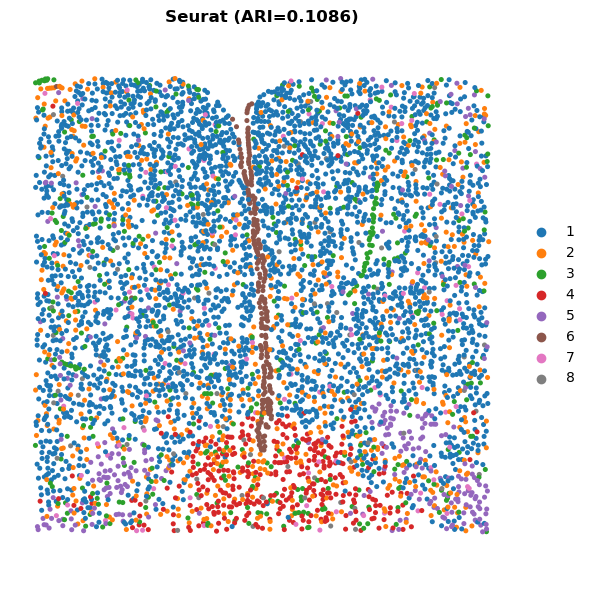

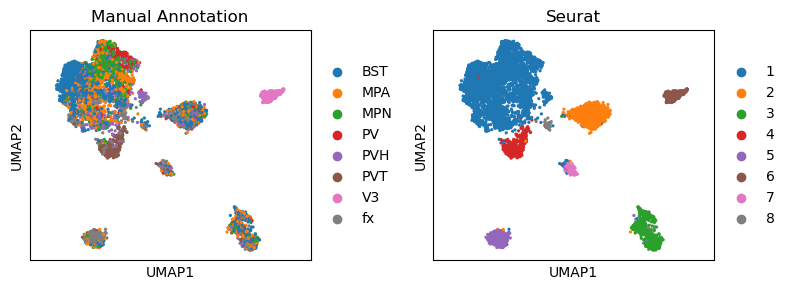

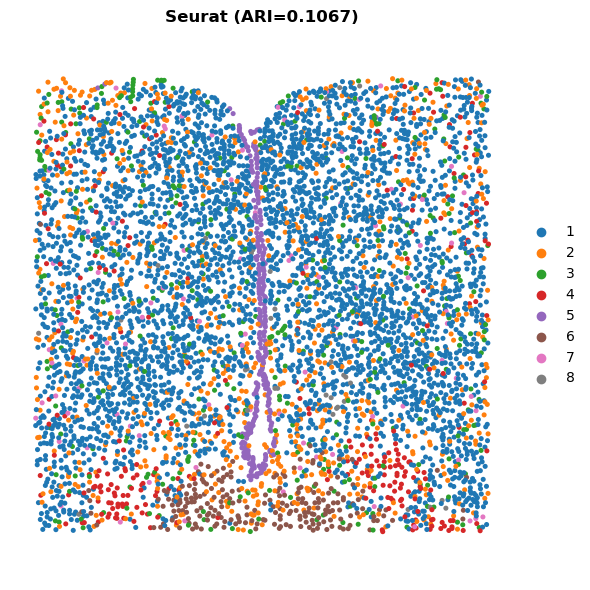

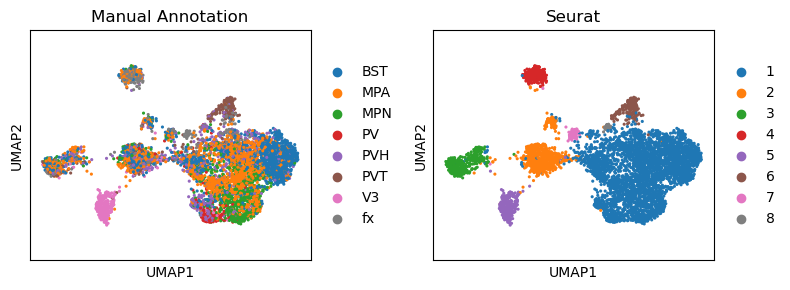

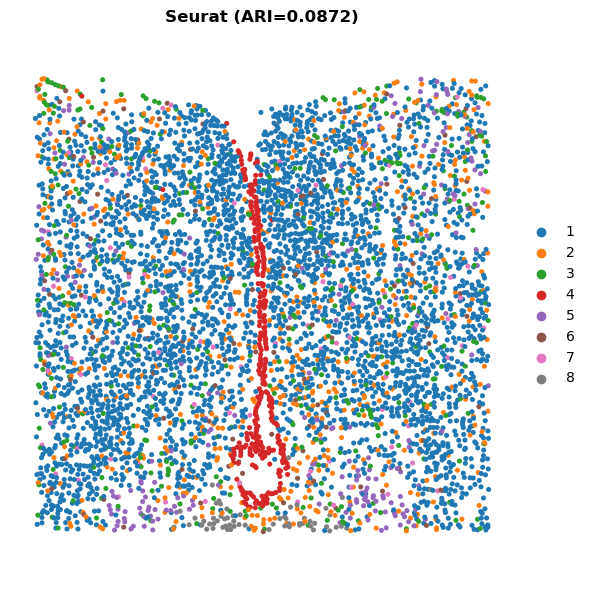

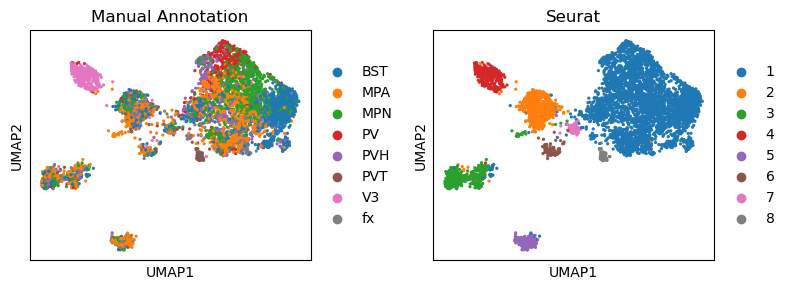

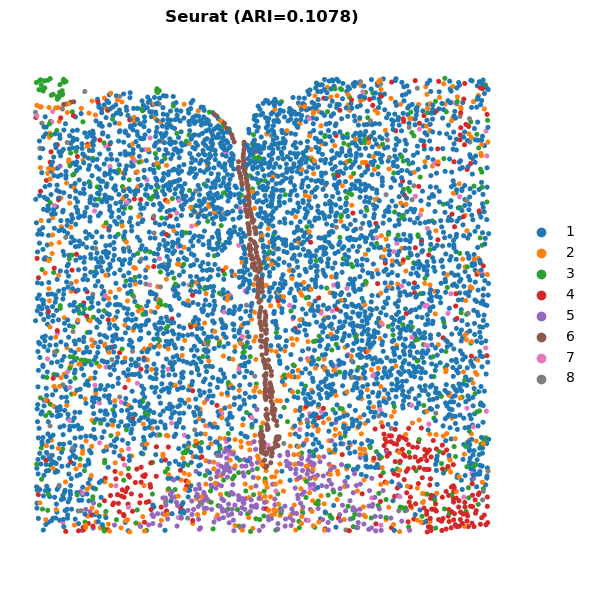

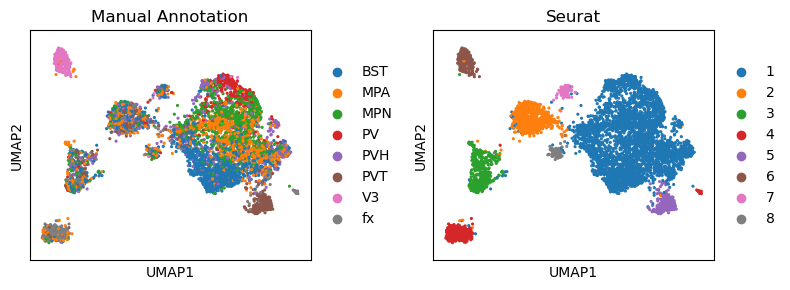

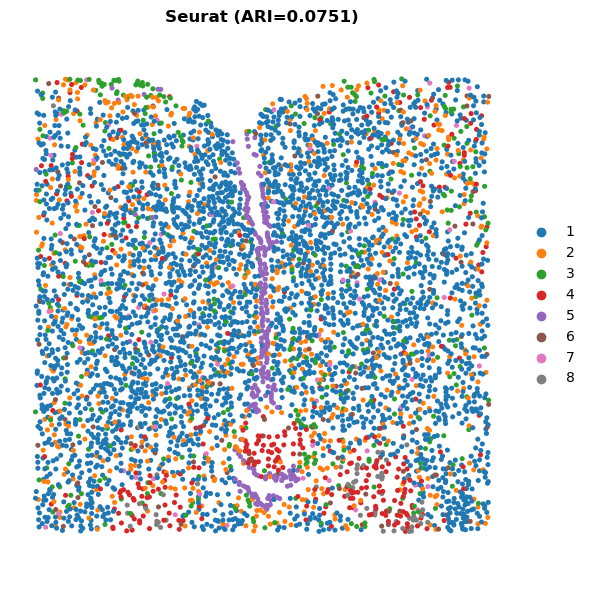

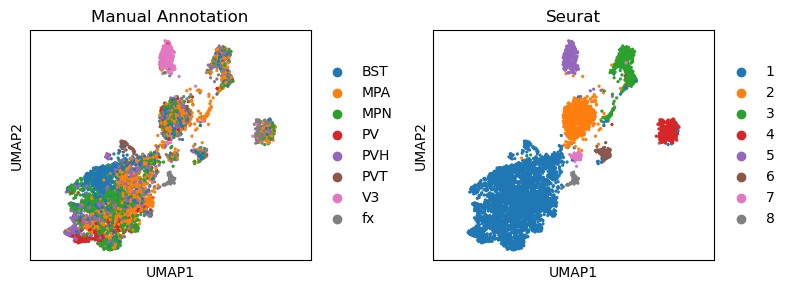

In [18]:
print(f'================= Processing {method} {dataset} =================')
metrics_list = []
for i, file in enumerate(files):
    section_id = file.split('/')[-1]
    out_path = os.path.join(output_dir, section_id)
    os.makedirs(out_path, exist_ok=True)
    
    print(f'[{i + 1}] Processing {section_id}')

    file_path = os.path.join(data_folder, section_id)

    adata = load_mHypothalamus(data_folder, section_id)

    metadata = pd.read_csv(file + '/cell_metadata.csv', index_col=0)
    gt_metadata = adata.obs

    # Match adata and metadata 
    adata = adata[adata.obs.index.isin(metadata.index)]
    # metadata = metadata.loc[adata.obs.index]
    gt_metadata = gt_metadata.loc[adata.obs.index]
    
    umap_coords = pd.read_csv(file + '/spatial_umap_coords.csv')
    metrics = pd.read_csv(file + '/metrics.csv', index_col=0)
    metrics.to_csv(os.path.join(out_path, 'metrics_old.csv'), index=False)

    # print(metadata.head())
    # print(umap_coords.head())
    # break
    
    adata.obs['gt'] = gt_metadata['layer_guess'].values
    pred = metadata[pred_key].values
    if min(pred) == 0:
        pred += 1
    
    adata.obs['pred'] = pred.astype(str)
    adata.obsm['X_umap'] = umap_coords[umap_keys].values
    adata = adata[~pd.isnull(adata.obs['gt'])]
    adata.obs['gt'] = adata.obs['gt'].astype(str)

    time_taken, memmory_used = metrics['Time'].values[0], metrics['Memory'].values[0]
    results = {
        method: section_id,
        'ARI': compute_ARI(adata, 'gt', 'pred'),
        'AMI': compute_NMI(adata, 'gt', 'pred'),
        'Homogeneity': compute_HOM(adata, 'gt', 'pred'),
        'Completeness': compute_COM(adata, 'gt', 'pred'),
        'ASW': compute_ASW(adata, 'pred'),
        'CHAOS': compute_CHAOS(adata, 'pred'),
        'PAS': compute_PAS(adata, 'pred'),
        'Time (s)': time_taken,
        'Memory (MB)': memmory_used
    }
    df_results = pd.DataFrame([results])
    metrics_list.append(results)

    plot_clustering(adata, results, out_path, show=False)
    plot_umap(adata, out_path, show=False)

    df_results.to_csv(os.path.join(out_path, 'metrics.csv'), index=False)
    print(f'    Results saved to {out_path}')
    # break

df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.sort_values(by=method)
df_metrics.to_csv(os.path.join(output_dir, 'metrics.csv'), index=False)
print(f'================= Finished {method} {dataset} =================')
# print(df_metrics)

## Combine all metrics

In [69]:
input_dir = f'../Results/MERFISH/{dataset}'
output_path = f'../Results/MERFISH/{dataset}/metrics.csv'
input_files = glob.glob(input_dir + '/*')
input_files = [f for f in input_files if os.path.isdir(f)]

all_metrics = []
for file in input_files:
    method = file.split('/')[-1]
    if method == 'GroundTruth':
        continue
    df_metrics = pd.read_csv(os.path.join(file, 'metrics.csv'))
    all_metrics.append(df_metrics)

with open(output_path, 'w') as f:
    for df in all_metrics:
        df.to_csv(f, index=False, header=True) 